In [29]:
import numpy as np
from pathlib import Path
import lmdb
import six
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import japanize_matplotlib
import json
import cv2

### helper function

In [40]:
def id2json_and_img(id_):
    path = Path('/Users/nakagawaayato/compe/kaggle/mga/original_data/train')
    img_path = path / 'images' / (id_ + '.jpg')
    json_path = path / 'annotations' / (id_ + '.json')

    img = cv2.imread(str(img_path))[:, :, ::-1]
    
    with open(json_path, 'r') as f:
        json_dict = json.load(f)
    return json_dict, img

def img_and_kp(img, kp):
    draw_img = img.copy()
    for coor in kp:
        cv2.circle(draw_img, (int(coor['x']), int(coor['y'])), 3, (255, 255, 0), -1)
    return draw_img
        

# 1. 画像サイズ

In [ ]:
w, h = [], []

In [ ]:
ROOT_DIR = Path.cwd().parents[2]
EXP_NAME = Path.cwd().stem
LMDB_DIR = ROOT_DIR / 'data' / EXP_NAME / 'lmdb'

env = lmdb.open(str(LMDB_DIR), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))
    for i in tqdm(range(n_samples), total=n_samples):
        i += 1
        
        # image
        img_key = f'image-{str(i).zfill(8)}'.encode()
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        w.append(img.size[0])
        h.append(img.size[1])
        break

100%|██████████| 60548/60548 [00:58<00:00, 1043.44it/s]


Text(0.5, 0, 'h')

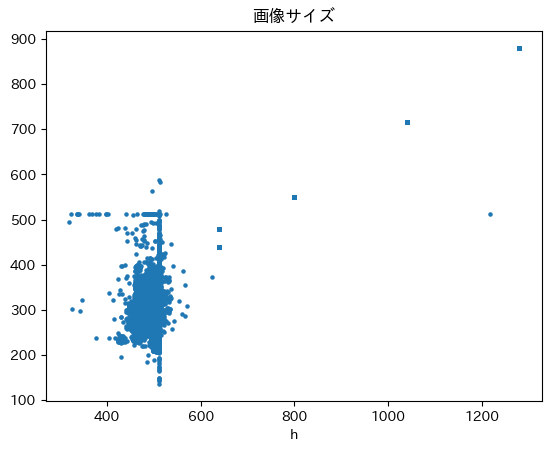

In [24]:
plt.scatter(w, h, s=5)
plt.title('画像サイズ')
plt.xlabel('w')
plt.xlabel('h')

(array([4.29205358e-06, 3.43364286e-06, 1.71682143e-06, 2.57523215e-06,
        5.15046429e-06, 5.40798750e-05, 1.33912072e-04, 1.41302988e-02,
        1.24160526e-02, 1.54342247e-02, 4.06972520e-03, 2.48939107e-05,
        4.29205358e-06, 8.58410715e-07, 0.00000000e+00, 8.58410715e-07,
        4.79079020e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.29205358e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.36921357e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.58410715e-07, 0.00000000e+00,
        0.00000000e+00, 2.30912482e-04]),
 array([ 318.  ,  337.24,  356.48,  375.72,  394.96,  414.2 ,  433.44,
         452.68,  471.9

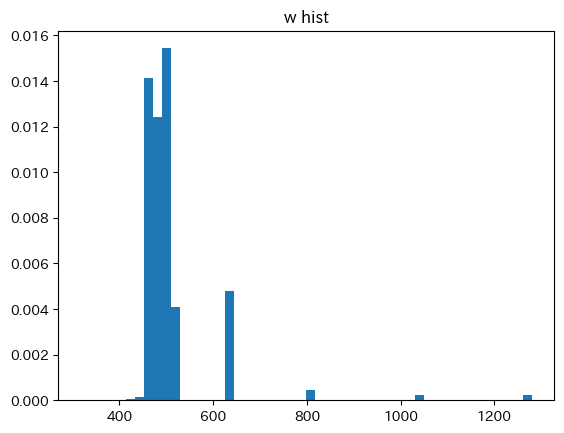

In [25]:
plt.title('w hist')
plt.hist(w, bins=50, density=True)
plt.show()

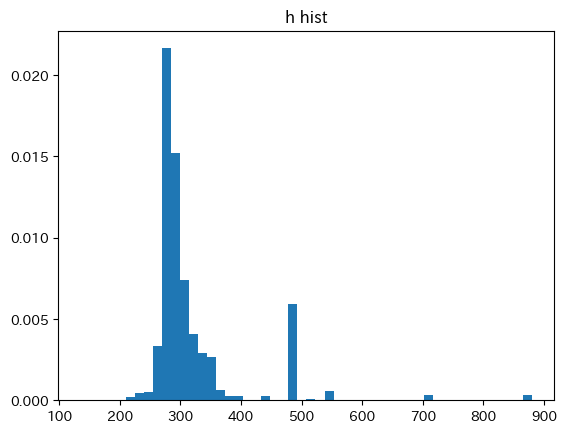

In [26]:
plt.title('h hist')
plt.hist(h, bins=50, density=True)
plt.show()

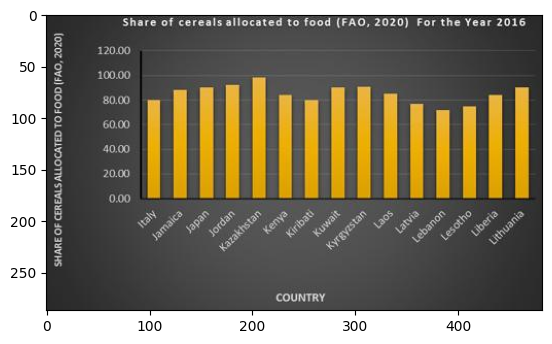

In [5]:
plt.imshow(img)

# 2. key point の数

In [12]:
n_keypoints_list = dict()

In [13]:
ROOT_DIR = Path.cwd().parents[2]
EXP_NAME = Path.cwd().stem
LMDB_DIR = ROOT_DIR / 'data' / EXP_NAME / 'lmdb'

env = lmdb.open(str(LMDB_DIR), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))
    for i in tqdm(range(n_samples), total=n_samples):
        i += 1
        label_key = f'label-{str(i).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
        json_dict = json.loads(label)
        chart_type = json_dict['chart-type']
        if chart_type not in n_keypoints_list:
            n_keypoints_list[chart_type] = []
        n_keypoints_list[chart_type].append(len(json_dict['key_point']))

100%|██████████| 60548/60548 [00:03<00:00, 19140.38it/s]


In [14]:
for i, v in n_keypoints_list.items():
    print(i, max(v))

scatter 196
vertical_bar 50
line 36
dot 10
horizontal_bar 27


In [66]:
invalid_ids = []
invalid_kp = []

In [67]:
ROOT_DIR = Path.cwd().parents[2]
EXP_NAME = Path.cwd().stem
LMDB_DIR = ROOT_DIR / 'data' / EXP_NAME / 'lmdb'

env = lmdb.open(str(LMDB_DIR), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))
    for i in tqdm(range(n_samples), total=n_samples):
        i += 1
        label_key = f'label-{str(i).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
        json_dict = json.loads(label)
        try:
            joints = np.array([[d['x'], d['y']] for d in json_dict['key_point']])
        except:
            continue
        if len(joints) < 0:
            continue
        h, w, min_x, min_y = json_dict['plot-bb'].values()
        max_x, max_y = min_x + w, min_y + h
        joint_min_x, joint_min_y = np.amin(joints, 0)
        joint_max_x, joint_max_y = np.amax(joints, 0)
        # if joint_min_x < max(min_x, 0) or \
        #    joint_min_y < max(min_y, 0) or \
        #    joint_max_x > max_x or \
        #    joint_max_y > max_y:
        if joint_min_x < 0 or joint_min_y < 0:
            invalid_ids.append(json_dict['id'])
            invalid_kp.append(json_dict['key_point'])

100%|██████████| 60548/60548 [00:03<00:00, 15616.73it/s]


In [71]:
i = 4
_, img = id2json_and_img(invalid_ids[i])
draw_img = img_and_kp(img, invalid_kp[i])

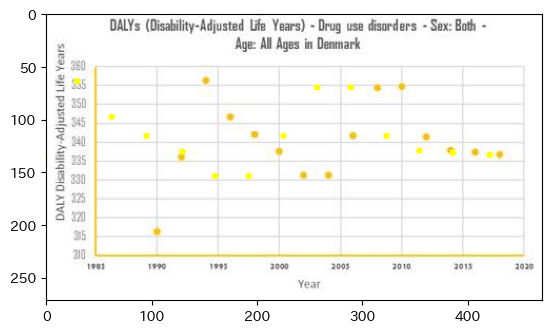

In [72]:
plt.imshow(draw_img)